## Import Libraries

Data shapes:
X_train: (154, 9)
X_test: (66, 9)
y_train: (154,)
y_test: (66,)


c:\Users\peymanhn\AppData\Local\anaconda3\envs\HabsEnv_2025\lib\site-packages\xgboost\core.py:160: UserWarning: [09:34:17] WARNING: D:\bld\xgboost-split_1713397764293\work\src\learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)



Random Forest:
Train - Accuracy: 0.9805, Precision: 0.9552, Recall: 1.0000, F1 Score: 0.9771
Test  - Accuracy: 0.8182, Precision: 0.7778, Recall: 0.7778, F1 Score: 0.7778


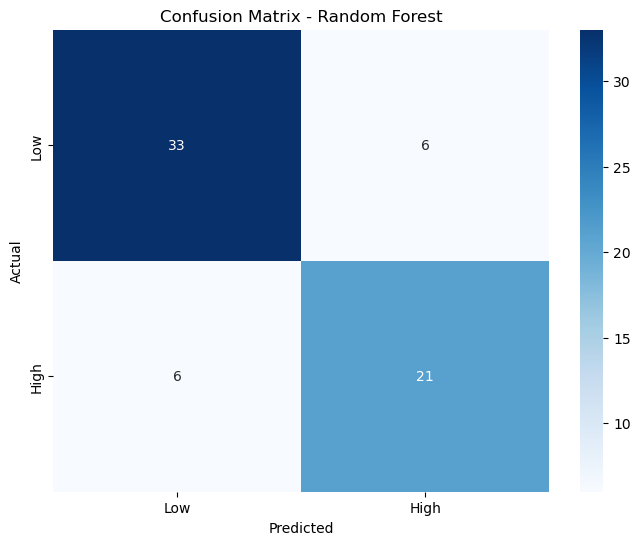


XGBoost:
Train - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test  - Accuracy: 0.8636, Precision: 0.8462, Recall: 0.8148, F1 Score: 0.8302


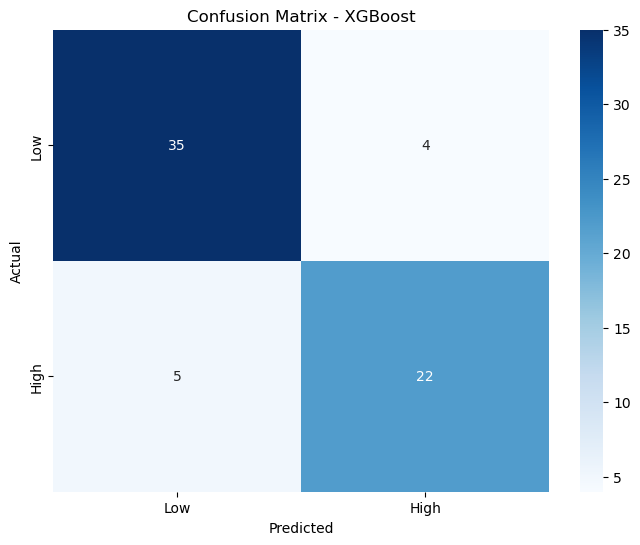


Feature combination processing completed in 2.12 seconds.


In [ ]:
import os
import time
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
data_path = r".\Data_2"
results_path = r".\Model"

# Create results directory if it doesn't exist
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Initialize results file
simulation_number = 1
result_file = os.path.join(results_path, f"{simulation_number}_results_with_9params.csv")
if not os.path.exists(result_file):
    pd.DataFrame(columns=[
        "Feature Combination Index", "Model", "Features", "Best Parameters", 
        "Train Accuracy", "Test Accuracy", "Train Precision", "Test Precision", 
        "Train Recall", "Test Recall", "Train F1", "Test F1"
    ]).to_csv(result_file, index=False)

# Load dataset
df = pd.read_csv(os.path.join(data_path, "UCDavis_Data_for_Analysis2_220days_ToxinProdMicrocystis.csv"))

# Classify target variable based on threshold
target_column = "ToxinProdc_Microcystis_CC"
threshold = 4000
y_continuous = df[target_column]
y = np.where(y_continuous <= threshold, 0, 1)  # Binary classification: 0 = Low, 1 = High

# Feature selection
# features = ["Q", "Q_1m", "WaterTemp", "DO", "pH", "SpecCond.", "OrgC", "OrgN", "PO4"]
features = ["Q", "Q_1m", "SpecCond.", "OrgC", "OrgN", "PO4", "WaterTemp", "DO", "pH"]
X = df[features]

# Create and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Save the scaler with feature names
scaler_with_headers = {
    "scaler": scaler,
    "feature_names": features
}
joblib.dump(scaler_with_headers, os.path.join(results_path, "scaler.pkl"))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=20, stratify=y)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Initialize dictionaries
start_time = time.time()
best_params = {}
models = {}

# Random Forest with fixed parameters
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced',
    criterion='log_loss',
    max_samples=None,
    random_state=42
)
rf.fit(X_train, y_train)
models['Random Forest'] = rf
best_params['Random Forest'] = rf.get_params()

# XGBoost with fixed parameters
xgb = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=1,
    n_estimators=100,
    min_child_weight=1,
    max_depth=9,
    learning_rate=0.1,
    lambda_=0.5,
    gamma=0,
    eval_metric='logloss',
    colsample_bytree=0.6,
    booster='gbtree',
    base_score=0.5,
    alpha=0.5,
    
    # Additional parameters from h5 file
    objective='binary:logistic',
    colsample_bylevel=None,
    colsample_bynode=None,
    early_stopping_rounds=None,
    enable_categorical=False,
    feature_types=None,
    grow_policy=None,
    importance_type=None,
    interaction_constraints=None,
    max_bin=None,
    max_cat_threshold=None,
    max_cat_to_onehot=None,
    max_delta_step=None,
    max_leaves=None,
    missing=float('nan'),
    monotone_constraints=None,
    multi_strategy=None,
    n_jobs=None,
    num_parallel_tree=None,
    random_state=42,
    sampling_method=None,
    tree_method=None,
    validate_parameters=None,
    verbosity=None
)
xgb.fit(X_train, y_train)
models['XGBoost'] = xgb
best_params['XGBoost'] = xgb.get_params()

# Create and save pipelines
rf_pipeline = Pipeline([
    ('scaler', scaler),
    ('rf', models['Random Forest'])
])
joblib.dump(rf_pipeline, os.path.join(results_path, 'rf_pipeline.joblib'))

xgb_pipeline = Pipeline([
    ('scaler', scaler),
    ('xgb', models['XGBoost'])
])
joblib.dump(xgb_pipeline, os.path.join(results_path, 'xgb_pipeline.joblib'))

# Evaluate models
for model_name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    results = {
        "Feature Combination Index": "All Features",
        "Model": model_name,
        "Features": features,
        "Best Parameters": best_params[model_name],
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Precision": train_precision,
        "Test Precision": test_precision,
        "Train Recall": train_recall,
        "Test Recall": test_recall,
        "Train F1": train_f1,
        "Test F1": test_f1,
    }

    # Print metrics
    print(f"\n{model_name}:")
    print(f"Train - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Test  - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")
    
    # Save results
    result_df = pd.DataFrame([results])
    result_df.to_csv(result_file, mode="a", header=False, index=False)

    # Create and save confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=["Low", "High"], 
        yticklabels=["Low", "High"]
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    conf_matrix_path = os.path.join(results_path, f"confusion_matrix_{model_name}_{simulation_number}.png")
    plt.savefig(conf_matrix_path, dpi=300, bbox_inches="tight")
    plt.show()

elapsed_time = time.time() - start_time
print(f"\nFeature combination processing completed in {elapsed_time:.2f} seconds.")

# Create feature importance dataframes for both models

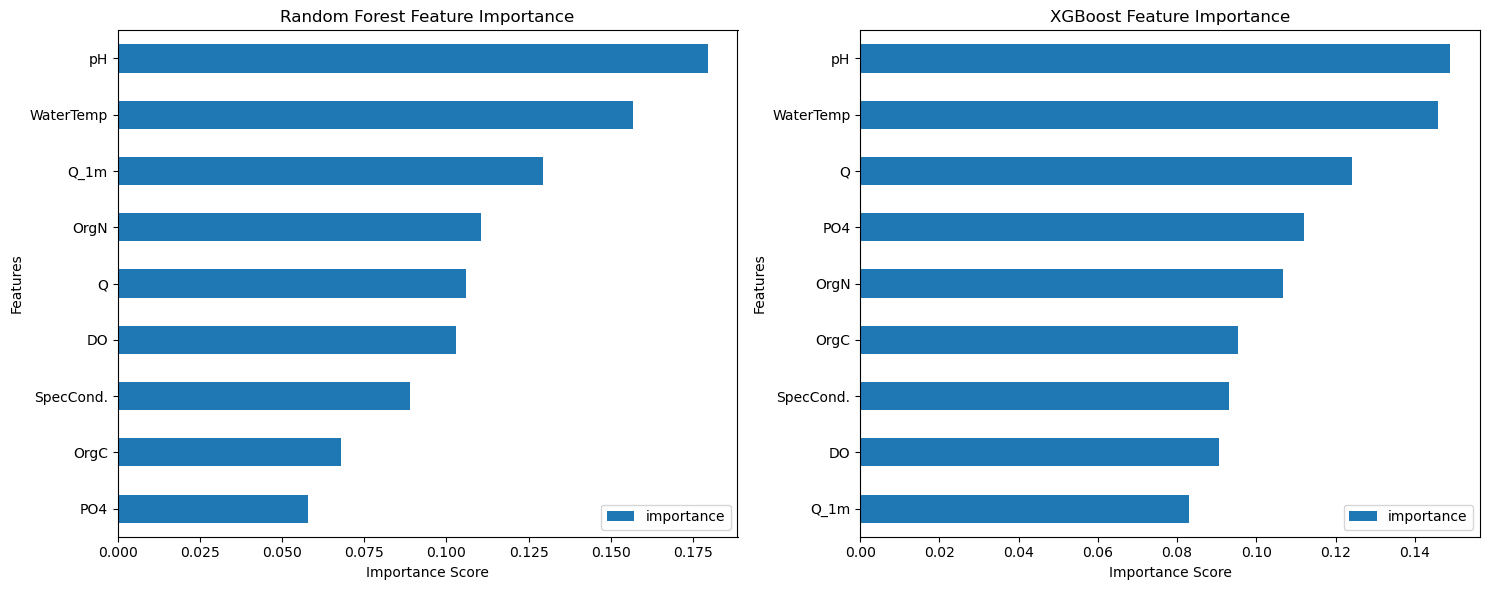


Random Forest Feature Importance:
     feature  importance
8         pH    0.179539
6  WaterTemp    0.156738
1       Q_1m    0.129499
4       OrgN    0.110618
0          Q    0.105870
7         DO    0.102839
2  SpecCond.    0.088922
3       OrgC    0.067943
5        PO4    0.058032

XGBoost Feature Importance:
     feature  importance
8         pH    0.149017
6  WaterTemp    0.145758
0          Q    0.124208
5        PO4    0.112048
4       OrgN    0.106782
3       OrgC    0.095469
2  SpecCond.    0.093196
7         DO    0.090603
1       Q_1m    0.082920


In [2]:
import matplotlib.pyplot as plt
import pandas as pd


# For Random Forest
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': models['Random Forest'].feature_importances_
}).sort_values('importance', ascending=True)

# For XGBoost
xgb_importance = pd.DataFrame({
    'feature': features,
    'importance': models['XGBoost'].feature_importances_
}).sort_values('importance', ascending=True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Random Forest feature importance
rf_importance.plot(kind='barh', x='feature', y='importance', ax=ax1)
ax1.set_title('Random Forest Feature Importance')
ax1.set_xlabel('Importance Score')
ax1.set_ylabel('Features')

# Plot XGBoost feature importance
xgb_importance.plot(kind='barh', x='feature', y='importance', ax=ax2)
ax2.set_title('XGBoost Feature Importance')
ax2.set_xlabel('Importance Score')
ax2.set_ylabel('Features')

# Adjust layout
plt.tight_layout()

# Save the plot
feature_importance_path = os.path.join(results_path, f"feature_importance_{simulation_number}.png")
plt.savefig(feature_importance_path, dpi=300, bbox_inches="tight")
plt.show()

# Print feature importance values
print("\nRandom Forest Feature Importance:")
print(rf_importance.sort_values('importance', ascending=False))
print("\nXGBoost Feature Importance:")
print(xgb_importance.sort_values('importance', ascending=False))

# Test one sample

In [9]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import joblib
import pandas as pd
import os

# Define the path where models are saved
model_path = r".\Model"

# Load the pipelines
rf_pipeline = joblib.load(os.path.join(model_path, 'rf_pipeline.joblib'))
xgb_pipeline = joblib.load(os.path.join(model_path, 'xgb_pipeline.joblib'))

# Create sample input with the correct features
sample_input = pd.DataFrame({
    "Q": [20.06470],
    "Q_1m": [90.02230],
    "WaterTemp": [22.63],
    "DO": [22.63],
    "pH": [7.96],
    "SpecCond.": [2910],
    "OrgC": [2.4],
    "OrgN": [0.3],
    "PO4": [0.08]
})

# Print original input data
print("Original Input Data:")
print(sample_input)
print("\n")

# Make predictions using both models
rf_prediction = rf_pipeline.predict(sample_input)
xgb_prediction = xgb_pipeline.predict(sample_input)

# Get prediction probabilities
rf_proba = rf_pipeline.predict_proba(sample_input)
xgb_proba = xgb_pipeline.predict_proba(sample_input)

# Print results
print("Model Predictions:")
print("-" * 50)
print("Random Forest:")
print(f"Prediction: {'High (1)' if rf_prediction[0] == 1 else 'Low (0)'}")
print(f"Probability - Low: {rf_proba[0][0]:.3f}, High: {rf_proba[0][1]:.3f}")
print("\nXGBoost:")
print(f"Prediction: {'High (1)' if xgb_prediction[0] == 1 else 'Low (0)'}")
print(f"Probability - Low: {xgb_proba[0][0]:.3f}, High: {xgb_proba[0][1]:.3f}")

# Print threshold reminder
print("\nNote: Predictions are based on threshold of 4000 for ToxinProdc_Microcystis_CC")
print("- Low (0): <= 4000")
print("- High (1): > 4000")

Original Input Data:
         Q     Q_1m  WaterTemp     DO    pH  SpecCond.  OrgC  OrgN   PO4
0  20.0647  90.0223      22.63  22.63  7.96       2910   2.4   0.3  0.08


Model Predictions:
--------------------------------------------------
Random Forest:
Prediction: Low (0)
Probability - Low: 0.546, High: 0.454

XGBoost:
Prediction: Low (0)
Probability - Low: 0.560, High: 0.440

Note: Predictions are based on threshold of 4000 for ToxinProdc_Microcystis_CC
- Low (0): <= 4000
- High (1): > 4000


# Test the models on all dataset

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import joblib
import pandas as pd
import os
import numpy as np

# Define paths
model_path = r".\Model"
data_path = r".\Data_2"

# Load test data
test_df = pd.read_csv(os.path.join(data_path, "Test.csv"))

# Load the pipelines
rf_pipeline = joblib.load(os.path.join(model_path, 'rf_pipeline.joblib'))
xgb_pipeline = joblib.load(os.path.join(model_path, 'xgb_pipeline.joblib'))

# Ensure correct feature order and create DataFrame with proper feature names
features = ["Q", "Q_1m", "WaterTemp", "DO", "pH", "SpecCond.", "OrgC", "OrgN", "PO4"]
X_test = pd.DataFrame(test_df[features], columns=features)

# Get predictions
rf_predictions = rf_pipeline.predict(X_test)
xgb_predictions = xgb_pipeline.predict(X_test)

# Get probabilities
rf_probas = rf_pipeline.predict_proba(X_test)
xgb_probas = xgb_pipeline.predict_proba(X_test)

# Create binary target from original values
threshold = 4000
observed_binary = np.where(test_df['ToxinProdc_Microcystis_CC'] <= threshold, 0, 1)

# Create results DataFrame
results_df = test_df.copy()
results_df['Observed_Binary'] = observed_binary
results_df['RF_Prediction'] = rf_predictions
results_df['RF_Prob_Low'] = rf_probas[:, 0]
results_df['RF_Prob_High'] = rf_probas[:, 1]
results_df['XGB_Prediction'] = xgb_predictions
results_df['XGB_Prob_Low'] = xgb_probas[:, 0]
results_df['XGB_Prob_High'] = xgb_probas[:, 1]

# Save results
output_path = os.path.join(model_path, 'test_results.csv')
results_df.to_csv(output_path, index=False)

# Print sample of results and accuracies
print("\nFirst few rows of results:")
print(results_df.head())

# Calculate and print accuracy for both models
rf_accuracy = (results_df['Observed_Binary'] == results_df['RF_Prediction']).mean()
xgb_accuracy = (results_df['Observed_Binary'] == results_df['XGB_Prediction']).mean()

print("\nModel Accuracy on Test Data:")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Print some statistics about predictions
print("\nPrediction Statistics:")
print("\nRandom Forest Predictions:")
print(pd.Series(rf_predictions).value_counts())
print("\nXGBoost Predictions:")
print(pd.Series(xgb_predictions).value_counts())
print("\nObserved Values:")
print(pd.Series(observed_binary).value_counts())



First few rows of results:
         Q      Q_1m  WaterTemp    DO    pH  SpecCond.  OrgC  OrgN   PO4  \
0  20.0647   90.0223      22.63  7.96  8.17     2910.0   2.4   0.3  0.08   
1  65.2032   75.2780      22.76  7.61  7.88     4214.0   2.3   0.4  0.08   
2  90.3902  147.2449      22.08  8.08  7.75     4448.0   2.5   0.4  0.09   
3  98.6538   98.2576      21.15  8.35  8.03     4164.0   3.0   1.6  0.06   
4 -37.6673   45.3083      20.65  8.25  7.83     5404.0   2.1   0.4  0.09   

   ToxinProdc_Microcystis_CC  Observed_Binary  RF_Prediction  RF_Prob_Low  \
0                     173314                1              1     0.348276   
1                      11175                1              1     0.065985   
2                      16333                1              1     0.188058   
3                      72439                1              1     0.231270   
4                      23857                1              1     0.114347   

   RF_Prob_High  XGB_Prediction  XGB_Prob_Low  XGB_P